### Replacing the Linear Model
We are going to keep all the loss function, data, and optimizer intact. We are however going to replace our linear model with the simplest possible neural network:
* a linear module
* an activation function
* a linear module (fed from above)

The first linear layer and the activation function is referred to as a *hidden layer* since its outputs are not observed directly, but fed into the output layer.

`nn` provides a simple way to concatenate modules through the `nn.Sequential` container:

In [1]:
import torch
import torch.nn as nn

seq_model = nn.Sequential(
            nn.Linear(1, 13), # linear layer, input size =1 , output size = 13
            nn.Tanh(),        # tanh activation layer
            nn.Linear(13,1))  # output layer, input size = 13, output size = 1

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

#### Inspecting the parameters in the model
Calling `model.parameters()` will collect `weight` and `bias` from both the first and second linear modules.

In [2]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

#### Using Named Parameters
You can inspect the parameters of a model and idenitfy the parameters by name using the method `named_parameters()`

In [3]:
for name, param in seq_model.named_parameters():
    print(f"Parameter {name} has a shape of {param.shape}")

Parameter 0.weight has a shape of torch.Size([13, 1])
Parameter 0.bias has a shape of torch.Size([13])
Parameter 2.weight has a shape of torch.Size([1, 13])
Parameter 2.bias has a shape of torch.Size([1])


#### Using Named Modules
When creating our network, we can also use the type `OrderedDict` so that we can name each module passed to `nn.Sequential`.

In [4]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([ # pass in an ordered dictionary so we can assign keys to each layer
            ('hidden_linear', nn.Linear(1, 13)), 
            ('hidden_activation', nn.Tanh()),
            ('output_linear', nn.Linear(13, 1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [5]:
# this allows us to get more explanatory names for submodules
for name, param in seq_model.named_parameters():
    print(f"Parameter {name} has a shape of {param.shape}")

Parameter hidden_linear.weight has a shape of torch.Size([13, 1])
Parameter hidden_linear.bias has a shape of torch.Size([13])
Parameter output_linear.weight has a shape of torch.Size([1, 13])
Parameter output_linear.bias has a shape of torch.Size([1])


We can also now access a particular submodule, or a particular parameter of a submodule, using the submodule key as an attribute.

In [6]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.1772], requires_grad=True)

### Using the Sequential model
First we need to bring back in our training loop and data

In [7]:
def training_loop(num_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, num_epochs + 1):
        t_p_train = model(t_u_train) # forward pass on training data
        loss_train = loss_fn(t_p_train, t_c_train) # evaluating the loss

        with torch.no_grad(): # we don't need a graph for validation - switch it off!
            t_p_val = model(t_u_val) # evaluating the validation data
            loss_val = loss_fn(t_p_val, t_c_val) # calculating loss for validation set

        optimizer.zero_grad() # zeroing the gradient
        loss_train.backward() # backward pass on loss_train
        optimizer.step() # update the parameters

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training Loss {loss_train.item():.4f}, Validation loss {loss_val.item():.4f}")


# TRAINING DATA -----------------------------------------------------------------------

#just copying our split data from the last chapter - t_u already normalized
t_c_train = torch.tensor([6.0, 13.0, 3.0, 11.0, 15.0, -4.0, 0.5, 21.0, 28.0])
t_u_train = torch.tensor([4.84, 6.04, 3.39, 5.63, 5.82, 2.18, 3.57, 6.84, 8.19])

t_c_val = torch.tensor([8.0, 14.0])
t_u_val = torch.tensor([4.89, 5.59])

# batching the data
t_c_train = t_c_train.unsqueeze(1)
t_u_train = t_u_train.unsqueeze(1)
t_c_val = t_c_val.unsqueeze(1)
t_u_val = t_u_val.unsqueeze(1)

t_c_train, t_u_train, t_c_val, t_u_val

(tensor([[ 6.0000],
         [13.0000],
         [ 3.0000],
         [11.0000],
         [15.0000],
         [-4.0000],
         [ 0.5000],
         [21.0000],
         [28.0000]]),
 tensor([[4.8400],
         [6.0400],
         [3.3900],
         [5.6300],
         [5.8200],
         [2.1800],
         [3.5700],
         [6.8400],
         [8.1900]]),
 tensor([[ 8.],
         [14.]]),
 tensor([[4.8900],
         [5.5900]]))

Now we can take our new model for a spin!

In [8]:
optimizer = torch.optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    num_epochs= 5000,
    optimizer= optimizer,
    model= seq_model,
    loss_fn= nn.MSELoss(),
    t_u_train= t_u_train,
    t_u_val= t_u_val,
    t_c_train= t_c_train,
    t_c_val= t_c_val)

print('output', seq_model(t_u_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training Loss 202.9742, Validation loss 132.7689
Epoch 1000, Training Loss 4.8106, Validation loss 1.0434
Epoch 2000, Training Loss 4.1011, Validation loss 0.7148
Epoch 3000, Training Loss 2.7889, Validation loss 0.6280
Epoch 4000, Training Loss 1.9897, Validation loss 1.5756
Epoch 5000, Training Loss 1.7294, Validation loss 2.3377
output tensor([[ 6.8566],
        [11.0422]], grad_fn=<AddmmBackward0>)
answer tensor([[ 8.],
        [14.]])
hidden tensor([[-7.7456e+00],
        [-9.7590e-02],
        [-1.0181e-01],
        [ 8.6522e+00],
        [-9.6145e-03],
        [-2.0005e-01],
        [-8.7142e+00],
        [-8.2090e+00],
        [ 9.2020e+00],
        [-9.6677e+00],
        [ 9.2032e-02],
        [-1.2771e-01],
        [ 8.0314e+00]])


#### Comparing to the linear model

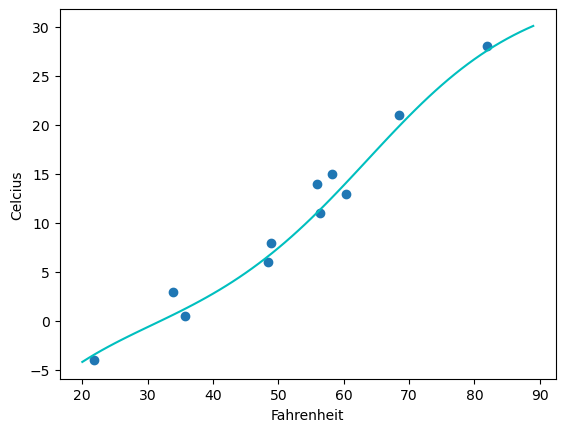

In [9]:
# Bringing our initial data back in to plot
# OUR DATA
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # temps in celcius

t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # temps in unknown unit

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)


from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celcius")

plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')


### Chapter 6 Exercises
1. Experiment with the number of hidden neurons in the neural network, as well as the learning rate.
    * what changes result in a more linear model
    * can you get the model to obviously overfit

In [172]:
# re-writing the training loop so we don't have a ton of output from all the epochs
def training_loop(num_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, num_epochs + 1):
        t_p_train = model(t_u_train) # forward pass on training data
        loss_train = loss_fn(t_p_train, t_c_train) # evaluating the loss

        with torch.no_grad(): # we don't need a graph for validation - switch it off!
            t_p_val = model(t_u_val) # evaluating the validation data
            loss_val = loss_fn(t_p_val, t_c_val) # calculating loss for validation set

        optimizer.zero_grad() # zeroing the gradient
        loss_train.backward() # backward pass on loss_train
        optimizer.step() # update the parameters

        if epoch == 1 or epoch % 100000 == 0:
            print(f"Epoch {epoch}, Training Loss {loss_train.item():.4f}, Validation loss {loss_val.item():.4f}")



# aiming for overfit
# Adding more neurons should allow the model to better fit to the training points - leading to an overfit

seq_model = nn.Sequential(OrderedDict([ # pass in an ordered dictionary so we can assign keys to each layer
            ('hidden_linear', nn.Linear(1, 300)), 
            ('hidden_activation', nn.Tanh()),
            ('output_linear', nn.Linear(300, 1))
]))

# seq_model.hidden_linear.bias

In [173]:
optimizer = torch.optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    num_epochs= 1000000,
    optimizer= optimizer,
    model= seq_model,
    loss_fn= nn.MSELoss(),
    t_u_train= t_u_train,
    t_u_val= t_u_val,
    t_c_train= t_c_train,
    t_c_val= t_c_val)

Epoch 1, Training Loss 196.6404, Validation loss 126.7119
Epoch 100000, Training Loss 1.8570, Validation loss 2.7369
Epoch 200000, Training Loss 1.7578, Validation loss 2.9875
Epoch 300000, Training Loss 1.6400, Validation loss 3.2553
Epoch 400000, Training Loss 1.5112, Validation loss 3.6490
Epoch 500000, Training Loss 1.3967, Validation loss 4.1486
Epoch 600000, Training Loss 1.3173, Validation loss 4.6650
Epoch 700000, Training Loss 1.2732, Validation loss 5.0837
Epoch 800000, Training Loss 1.2487, Validation loss 5.3291
Epoch 900000, Training Loss 1.2305, Validation loss 5.3950
Epoch 1000000, Training Loss 1.2131, Validation loss 5.3994


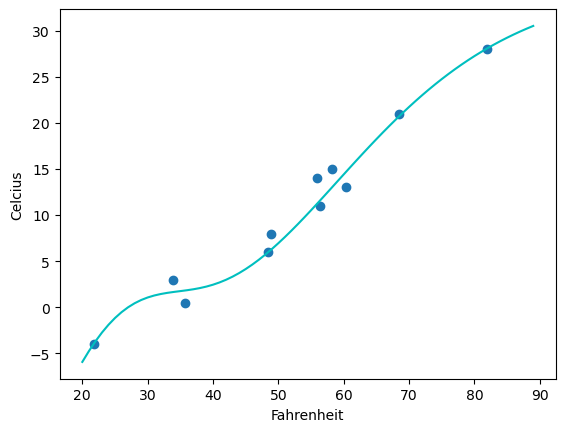

In [174]:
fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celcius")

plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')

### Using a Neural Network on the Wine Data

In [176]:
# loading the winequality.csv
import csv
import numpy as np

wine_path = "../chap04/data/winequality.csv"
wineq_np = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)
wineq_np

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [177]:
# checking the header row against the shape to make sure all data has been read
col_list = next(csv.reader(open(wine_path), delimiter=";"))

wineq_np.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

So, what I think we need to do is to seperate the quality from all the other elements. We can then map all values of each column from 0 to 1 giving each wine a 11D vector. The output would be a one hot encoded score between 0 and 10 (aka a 10D vector.)

In [196]:
# split out the wine properties from the quality
wine_props = wineq_np[:,:-1]
wine_quality = wineq_np[:,[-1]]

wine_props.shape, wine_quality.shape

((4898, 11), (4898, 1))

#### Normalizing the Wine qualities
Remember that to normal data we subtract the *mean* ($\mu$) from each *feature* and then divide by the *standard deviation* ($\sigma$).

In [197]:
properties_mean = np.mean(wine_props, axis=0)
properties_mean

array([6.8547821e+00, 2.7824137e-01, 3.3419210e-01, 6.3914142e+00,
       4.5772403e-02, 3.5308086e+01, 1.3836066e+02, 9.9402541e-01,
       3.1882715e+00, 4.8984632e-01, 1.0514250e+01], dtype=float32)

In [199]:
properties_variance = np.var(wine_props, axis=0)
properties_stand_dev = np.sqrt(properties_variance) # standard deviation is the square root of variance
properties_stand_dev

array([8.43779683e-01, 1.00783534e-01, 1.21007159e-01, 5.07154417e+00,
       2.18457766e-02, 1.70053997e+01, 4.24937134e+01, 2.99060741e-03,
       1.50985211e-01, 1.14113800e-01, 1.23049569e+00], dtype=float32)

In [200]:
normalize_wine_props = (wine_props - properties_mean) / properties_stand_dev
normalize_wine_props

array([[ 1.7210405e-01, -8.1772834e-02,  2.1327595e-01, ...,
        -1.2469534e+00, -3.4918064e-01, -1.3931375e+00],
       [-6.5749615e-01,  2.1589485e-01,  4.7996387e-02, ...,
         7.3999584e-01,  1.3468185e-03, -8.2426113e-01],
       [ 1.4757624e+00,  1.7449627e-02,  5.4383487e-01, ...,
         4.7506949e-01, -4.3681240e-01, -3.3665249e-01],
       ...,
       [-4.2046770e-01, -3.7944067e-01, -1.1915997e+00, ...,
        -1.3131850e+00, -2.6154864e-01, -9.0552950e-01],
       [-1.6056112e+00,  1.1667209e-01, -2.8256249e-01, ...,
         1.0049222e+00, -9.6260333e-01,  1.8575851e+00],
       [-1.0130395e+00, -6.7710835e-01,  3.7855527e-01, ...,
         4.7506949e-01, -1.4883943e+00,  1.0449045e+00]], dtype=float32)